#### This notebook plots the loss by equal shares across different impact areas in terms of 3 proposed impact metrics with 3 varieties each- cost share, project share, popularity share; cost representation, project representation, popularity representation; cost proportionality, project proportionality, popularity proportionality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 10)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()

(19077, 21)
(19110, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.0000,0.7000,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.0000,3.5000,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.0000,5.0000,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.0000,39.0000,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.0000,16.8000,True,True,True,NaN,NaN,cumulative


In [6]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]
print(invalid_projects)

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN   295110.0000          0.0000           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
    project_id  election_id
893          5           72
(19110, 22)
(19109, 22)


In [7]:
# setting up vote_percent column
print(valid_pbprojects_df.shape)
valid_pb_projects_total_selections = valid_pbprojects_df.groupby(['election_id'])['votes'].sum().reset_index()
print(valid_pb_projects_total_selections.shape)
valid_pb_projects_total_selections.rename(columns={'votes': 'all_project_votes'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_total_selections, on='election_id', how='inner')
valid_pbprojects_df['vote_percent'] = round((valid_pbprojects_df['votes'] / valid_pbprojects_df['all_project_votes'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 22)
(812, 2)
(19109, 24)


In [8]:
aarau_election_id = valid_pbprojects_df[valid_pbprojects_df['country'] == 'Switzerland'].groupby(['election_id']).first().reset_index()['election_id']
green_budget_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Wieliczka'].groupby(['election_id']).first().reset_index()['election_id']


In [9]:
# print("Distinct election IDs are: ", valid_pbprojects_df['election_id'].nunique())
# valid_pbprojects_df_grouped_election = valid_pbprojects_df.groupby(['election_id','is_mes_winner'])['cost'].agg(['sum']).reset_index()
# print(valid_pbprojects_df_grouped_election.head())
# print(valid_pbprojects_df_grouped_election.shape)
# print("Unique election IDs after grouping total costs: ", valid_pbprojects_df_grouped_election['election_id'].nunique())
# mes_winners_grouped_project_count = valid_pbprojects_df_grouped_election[valid_pbprojects_df_grouped_election['is_mes_winner'] == True]
# print(mes_winners_grouped_project_count.shape)

In [10]:
# setting additional column for used budget with MES aggregation
# print(valid_pbprojects_df.shape)

# elections_with_mes_winners = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True]
# elections_with_greedy_winners = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True]
# print("Elections with MES winners: ", elections_with_mes_winners['election_id'].nunique())
# print("Elections with Greedy Winners: ", elections_with_greedy_winners['election_id'].nunique())

# # Getting the total budget usage for MES winning projects of each election_id (grouped) and adding a new column to denote that value
# valid_pb_projects_mes_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
# valid_pb_projects_mes_budget_usage.rename(columns={'cost': 'mes_total_budget_usage'}, inplace=True)
# valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_mes_budget_usage, on='election_id', how='inner')
# valid_pbprojects_df['mes_budget_usage_percent'] = round((valid_pbprojects_df['mes_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
# print(valid_pbprojects_df.shape)

# # Getting the total budget usage for utilitarian greedy winning projects of each election_id (grouped) and adding a new column to denote that value
# valid_pb_projects_greedy_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner']].groupby(['election_id'])['cost'].sum().reset_index()
# valid_pb_projects_greedy_budget_usage.rename(columns={'cost': 'greedy_total_budget_usage'}, inplace=True)
# valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_greedy_budget_usage, on='election_id', how='inner')
# valid_pbprojects_df['greedy_budget_usage_percent'] = round((valid_pbprojects_df['greedy_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
# print(valid_pbprojects_df.shape)

## Fill empty values for category with the label 'uncategorized' to aid in further data analysis

In [11]:
valid_pbprojects_df['category'].value_counts()

# Checking to see if there are empty values for category in the entire project dataset
na_category_count = valid_pbprojects_df['category'].isna().sum()
print("Empty category values for PB projects are: ", na_category_count)

# Fill such empty values of category with the label uncategorized, so that it can aid in further data preprocessing
valid_pbprojects_df['category'].fillna('uncategorized', inplace=True)


print("Emtpy category values after filling na: ", valid_pbprojects_df['category'].isna().sum())
print("`uncategorized` category count for valid pb projects: ", valid_pbprojects_df[valid_pbprojects_df['category'] == 'uncategorized'].shape[0])

Empty category values for PB projects are:  8182
Emtpy category values after filling na:  0
`uncategorized` category count for valid pb projects:  8182


## Create additional columns for each category label

In [12]:
# Split the Categories column and create a set of unique categories
categories_set = set(category.strip() for categories in valid_pbprojects_df['category'] for category in categories.split(','))

# Create new columns with default value 0
for category in categories_set:
    valid_pbprojects_df[f'category_{category}'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    categories = row['category'].split(',')
    for category in categories:
        valid_pbprojects_df.at[index, f'category_{category.strip()}'] = 1
    
    if(len(categories) == 1 and (categories[0] == 'uncategorized')):
        valid_pbprojects_df.at[index, 'category_labels_count'] = 0
    else:
        valid_pbprojects_df.at[index, 'category_labels_count'] = int(len(categories))

valid_pbprojects_df.tail()

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,all_project_votes,vote_percent,category_health,category_public transit and roads,category_uncategorized,category_environmental protection,category_culture,category_education,category_sport,category_welfare,category_urban greenery,category_public space,category_labels_count
19104,1000,Switzerland,Aarau,Aarau,2023,18,5000,1703,88,146.0000,"health,education,welfare",Processing birth,NaN,"adults,families with children",50000.0000,10.0000,False,False,False,NaN,NaN,cumulative,8262,1.0650,1,0,0,0,0,1,0,1,0,0,3.0000
19105,1000,Switzerland,Aarau,Aarau,2023,17,3500,1703,67,102.0000,welfare,Senior Meeting,NaN,elderly,50000.0000,7.0000,False,False,False,NaN,NaN,cumulative,8262,0.8110,0,0,0,0,0,0,0,1,0,0,1.0000
19106,1000,Switzerland,Aarau,Aarau,2023,27,4000,1703,69,97.0000,"public space,public transit and roads",New edition of Telli-Map,NaN,"children,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.8350,0,1,0,0,0,0,0,0,0,1,2.0000
19107,1000,Switzerland,Aarau,Aarau,2023,19,500,1703,56,85.0000,"welfare,education,health",Ways of Remembering,NaN,"youth,adults,elderly",50000.0000,1.0000,True,False,True,NaN,NaN,cumulative,8262,0.6780,1,0,0,0,0,1,0,1,0,0,3.0000
19108,1000,Switzerland,Aarau,Aarau,2023,6,4000,1703,44,85.0000,welfare,New Year 2024 Greetings,NaN,"youth,adults,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.5330,0,0,0,0,0,0,0,1,0,0,1.0000


In [13]:
election_total_projects_cost_df = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
election_total_projects_cost_df.rename(columns={'cost': 'election_total_projects_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(election_total_projects_cost_df, on='election_id', how='inner')

In [14]:
categorization_df = valid_pbprojects_df
categorization_df = categorization_df[[
       'election_id', 'unit', 'subunit', 'instance', 'project_id', 'vote_type', 'cost', 'election_total_projects_cost', 'votes', 'score', 'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'category_public transit and roads',
       'category_health', 'category_welfare', 'category_uncategorized',
       'category_public space', 'category_urban greenery', 'category_culture',
       'category_education', 'category_sport',
       'category_environmental protection', 'category_labels_count'
]]
categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)

# update votes column to have score values for cumulative voting instances
categorization_df['votes'] = np.where(categorization_df['vote_type'] == 'cumulative', categorization_df['score'], categorization_df['votes'])

# In my earlier logic, I had put uncategorized to each undefined project categorization, however, this did not increase the total category counts. 
# So using this, we can the filter to remove uncategorized pb instances where uncategorized value is gre
# ater than 0
# Also, accordingly, uncategorized > 0 and total count values > 0 must not exists; sanity check
empty_df = categorization_df[(categorization_df['uncategorized'] > 0) & (categorization_df['total_tags'] > 0)]
print("Size of returned df must be 0: ", empty_df.shape)

# Apply an additional filter to remove uncategorized values from the categorization_df
categorization_df = categorization_df[categorization_df['uncategorized'] == 0]

Size of returned df must be 0:  (0, 24)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\2155016319.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\2155016319.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

## Create sorted ordering for the 344 PB instances with their % values of winnings in each category for MES and Greedy

In [15]:
# some globals to be used for the code snippets below
categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

category_title_map = {
    'education': 'Education',
    'public_transit_and_roads': 'Public Transit',
    'health': 'Health',
    'welfare': 'Welfare',
    'public_space': 'Public Space',
    'urban_greenery': 'Urban Greenery', 
    'culture': 'Culture', 
    'sport': 'Sport',
    'env_protection': 'Env. Protection'
}

oneD_to_twoD_map = {
    0: [0,0],
    1: [0,1],
    2: [0,2],
    3: [1,0],
    4: [1,1],
    5: [1,2],
    6: [2,0],
    7: [2,1],
    8: [2,2]
}

## Use the categorization_df dataframe as a base and add new metrics necessary for calculating cost utilization and relative winners for each category of each PB instance

In [16]:
# winning totals for UG and ES; cost, projects, votes
es_total_cost = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
es_total_cost.rename(columns={'cost': 'es_total_cost'}, inplace=True)

ug_total_cost = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
ug_total_cost.rename(columns={'cost': 'ug_total_cost'}, inplace=True)

es_total_projects = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
es_total_projects.rename(columns={'project_id': 'es_total_projects'}, inplace=True)

ug_total_count = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
ug_total_count.rename(columns={'project_id': 'ug_total_projects'}, inplace=True)

es_total_popularity = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
es_total_popularity.rename(columns={'votes': 'es_total_popularity'}, inplace=True)

ug_total_popularity = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
ug_total_popularity.rename(columns={'votes': 'ug_total_popularity'}, inplace=True)

# Merge these dataset with categorization_df
categorization_df = categorization_df.merge(es_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(ug_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(es_total_projects, on='election_id', how='inner')
categorization_df = categorization_df.merge(ug_total_count, on='election_id', how='inner')
categorization_df = categorization_df.merge(es_total_popularity, on='election_id', how='inner')
categorization_df = categorization_df.merge(ug_total_popularity, on='election_id', how='inner')

In [17]:
print("Shape of categorization_df : ", categorization_df.shape)

# for each category; add columns that signify the total cost of each category per PB instance
# Create columns to store selection of percentages

# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # category total cost
    category_total_cost = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['cost'].sum().reset_index()
    category_total_cost.rename(columns={'cost': f'{category}_total_cost'}, inplace=True)

    # category total projects
    category_total_projects = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['project_id'].count().reset_index()
    category_total_projects.rename(columns={'project_id': f'{category}_total_projects'}, inplace=True)

    # category total popularity
    category_total_popularity = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['votes'].sum().reset_index()
    category_total_popularity.rename(columns={'votes': f'{category}_total_popularity'}, inplace=True)

    # merge
    categorization_df = categorization_df.merge(category_total_cost, how='left', on='election_id')
    categorization_df = categorization_df.merge(category_total_projects, how='left', on='election_id')
    categorization_df = categorization_df.merge(category_total_popularity, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_total_projects'].fillna(0, inplace=True)
    categorization_df[f'{category}_total_popularity'].fillna(0, inplace=True)

Shape of categorization_df :  (10927, 30)


In [18]:
# Merge categorization_df with pbsummary to get total projects in all elections
pbsummary_num_votes = pbsummary_df[['election_id', 'num_projects']]
categorization_df = categorization_df.merge(pbsummary_num_votes, on='election_id', how='inner')
categorization_df

,election_id,unit,subunit,instance,project_id,vote_type,cost,election_total_projects_cost,votes,score,is_mes_winner,is_greedy_winner,is_phragmen_winner,public_transit_and_roads,health,welfare,uncategorized,public_space,urban_greenery,culture,education,sport,env_protection,total_tags,es_total_cost,ug_total_cost,es_total_projects,ug_total_projects,es_total_popularity,ug_total_popularity,education_total_cost,education_total_projects,education_total_popularity,public_transit_and_roads_total_cost,public_transit_and_roads_total_projects,public_transit_and_roads_total_popularity,health_total_cost,health_total_projects,health_total_popularity,welfare_total_cost,welfare_total_projects,welfare_total_popularity,public_space_total_cost,public_space_total_projects,public_space_total_popularity,urban_greenery_total_cost,urban_greenery_total_projects,urban_greenery_total_popularity,culture_total_cost,culture_total_projects,culture_total_popularity,sport_total_cost,sport_total_projects,sport_total_popularity,env_protection_total_cost,env_protection_total_projects,env_protection_total_popularity,num_projects
0,332,Warszawa,Aleksandrów,2017,261,approval,80000,287217,172.0000,NaN,False,True,False,1,0,0,0,1,0,0,0,0,0,2.0000,107950,110000,3,2,303.0000,290.0000,39200.0000,2.0000,217.0000,248017.0000,3.0000,398.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110000.0000,2.0000,290.0000,0.0000,0.0000,0.0000,30000.0000,1.0000,118.0000,9200.0000,1.0000,99.0000,0.0000,0.0000,0.0000,5
1,332,Warszawa,Aleksandrów,2017,1112,approval,99267,287217,140.0000,NaN,False,False,False,1,0,0,0,0,0,0,0,0,0,1.0000,107950,110000,3,2,303.0000,290.0000,39200.0000,2.0000,217.0000,248017.0000,3.0000,398.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110000.0000,2.0000,290.0000,0.0000,0.0000,0.0000,30000.0000,1.0000,118.0000,9200.0000,1.0000,99.0000,0.0000,0.0000,0.0000,5
2,332,Warszawa,Aleksandrów,2017,720,approval,30000,287217,118.0000,NaN,True,True,True,0,0,0,0,1,0,1,1,0,0,3.0000,107950,110000,3,2,303.0000,290.0000,39200.0000,2.0000,217.0000,248017.0000,3.0000,398.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110000.0000,2.0000,290.0000,0.0000,0.0000,0.0000,30000.0000,1.0000,118.0000,9200.0000,1.0000,99.0000,0.0000,0.0000,0.0000,5
3,332,Warszawa,Aleksandrów,2017,1206,approval,9200,287217,99.0000,NaN,True,False,True,0,0,0,0,0,0,0,1,1,0,2.0000,107950,110000,3,2,303.0000,290.0000,39200.0000,2.0000,217.0000,248017.0000,3.0000,398.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110000.0000,2.0000,290.0000,0.0000,0.0000,0.0000,30000.0000,1.0000,118.0000,9200.0000,1.0000,99.0000,0.0000,0.0000,0.0000,5
4,332,Warszawa,Aleksandrów,2017,2592,approval,68750,287217,86.0000,NaN,True,False,True,1,0,0,0,0,0,0,0,0,0,1.0000,107950,110000,3,2,303.0000,290.0000,39200.0000,2.0000,217.0000,248017.0000,3.0000,398.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110000.0000,2.0000,290.0000,0.0000,0.0000,0.0000,30000.0000,1.0000,118.0000,9200.0000,1.0000,99.0000,0.0000,0.0000,0.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10922,1000,Aarau,Aarau,2023,18,cumulative,5000,247330,146.0000,146.0000,False,False,False,0,1,1,0,0,0,0,1,0,0,3.0000,49400,49600,17,7,9292.0000,7132.0000,57800.0000,8.0000,3721.0000,8000.0000,2.0000,1288.0000,23300.0000,8.0000,3627.0000,91900.0000,15.0000,7434.0000,155730.0000,19.0000,10699.0000,76400.0000,8.0000,4494.0000,86700.0000,8.0000,4508.0000,33500.0000,6.0000,2289.0000,59600.0000,6.0000,4319.0000,33
10923,1000,Aarau,Aarau,2023,17,cumulative,3500,247330,102.0000,102.0000,False,False,False,0,0,1,0,0,0,0,0,0,0,1.0000,49400,49600,17,7,9292.0000,7132.0000,57800.0000,8.0000,3721.0000,8000.0000,2.0000,1288.0000,23300.0000,8.0000,3627.0000,91900.0000,15.0000,7434.0000,155730.0000,19.0000,10699.0000,76400.0000,8.0000,4494.0000,86700.0000,8.0000,4508.0000,33500.0000,6.0000,2289.0000,59600

In [19]:
# Adding total cost of each category in each election for greedy winners
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # category_ug_total_cost 
    category_ug_total_cost = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    category_ug_total_cost.rename(columns={'cost': f'{category}_ug_total_cost'}, inplace=True)
    categorization_df = categorization_df.merge(category_ug_total_cost, how='left', on='election_id')

    # category_ug_total_projects 
    category_ug_total_projects = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    category_ug_total_projects.rename(columns={'project_id': f'{category}_ug_total_projects'}, inplace=True)
    categorization_df = categorization_df.merge(category_ug_total_projects, how='left', on='election_id')

    # category_ug_total_popularity
    category_ug_total_popularity = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
    category_ug_total_popularity.rename(columns={'votes': f'{category}_ug_total_popularity'}, inplace=True)
    categorization_df = categorization_df.merge(category_ug_total_popularity, how='left', on='election_id')

    # category_es_total_cost 
    category_es_total_cost = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    category_es_total_cost.rename(columns={'cost': f'{category}_es_total_cost'}, inplace=True)
    categorization_df = categorization_df.merge(category_es_total_cost, how='left', on='election_id')

    # category_es_total_projects
    category_es_total_projects = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    category_es_total_projects.rename(columns={'project_id': f'{category}_es_total_projects'}, inplace=True)
    categorization_df = categorization_df.merge(category_es_total_projects, how='left', on='election_id')

    # category_es_total_popularity
    category_es_total_popularity = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['votes'].sum().reset_index()
    category_es_total_popularity.rename(columns={'votes': f'{category}_es_total_popularity'}, inplace=True)
    categorization_df = categorization_df.merge(category_es_total_popularity, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_ug_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_ug_total_projects'].fillna(0, inplace=True)
    categorization_df[f'{category}_ug_total_popularity'].fillna(0, inplace=True)
    categorization_df[f'{category}_es_total_cost'].fillna(0, inplace=True)
    categorization_df[f'{category}_es_total_projects'].fillna(0, inplace=True)
    categorization_df[f'{category}_es_total_popularity'].fillna(0, inplace=True)

##  Metrics for winning Share across cost, projects number and popularity 

In [20]:
# metrics calculation required for relative winners
print("Current shape of categorization df is: ", categorization_df.shape)

for category in categories_set:
    categorization_df[f'{category}_ug_cost_share'] = 1 * categorization_df[f'{category}_ug_total_cost'] / categorization_df['ug_total_cost']
    categorization_df[f'{category}_es_cost_share'] = 1 * categorization_df[f'{category}_es_total_cost'] / categorization_df['es_total_cost']
    categorization_df[f'{category}_loss_cost_share'] = categorization_df[f'{category}_ug_cost_share'] - categorization_df[f'{category}_es_cost_share']

    categorization_df[f'{category}_ug_project_share'] = 1 * categorization_df[f'{category}_ug_total_projects'] / categorization_df['ug_total_projects']
    categorization_df[f'{category}_es_project_share'] = 1 * categorization_df[f'{category}_es_total_projects'] / categorization_df['es_total_projects']
    categorization_df[f'{category}_loss_project_share'] = categorization_df[f'{category}_ug_project_share'] - categorization_df[f'{category}_es_project_share']

    categorization_df[f'{category}_ug_popularity_share'] = 1 * categorization_df[f'{category}_ug_total_popularity'] / categorization_df['ug_total_popularity']
    categorization_df[f'{category}_es_popularity_share'] = 1 * categorization_df[f'{category}_es_total_popularity'] / categorization_df['es_total_popularity']
    categorization_df[f'{category}_loss_popularity_share'] = categorization_df[f'{category}_ug_popularity_share'] - categorization_df[f'{category}_es_popularity_share']
    

Current shape of categorization df is:  (10927, 112)


In [21]:
categories_color_map = {
    'education': '#d53e4f',
    'public_transit_and_roads': '#f46d43',
    'health': '#fdae61',
    'welfare': '#fee08b',
    'public_space': '#ffffbf',
    'urban_greenery': '#e6f598',
    'culture': '#abdda4',
    'sport': '#66c2a5',
    'env_protection': '#3288bd'
}

## Metrics for Cost Representation and Project Representation

In [22]:
# New metrics required relative proposals in each category
print("Before adding new metrics, shape was: ", categorization_df.shape)
for category in categories_set:
    categorization_df[f'{category}_ug_cost_rep'] = 1 * categorization_df[f'{category}_ug_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'{category}_es_cost_rep'] = 1 * categorization_df[f'{category}_es_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'{category}_loss_cost_rep'] = categorization_df[f'{category}_ug_cost_rep'] - categorization_df[f'{category}_es_cost_rep']
    
    categorization_df[f'{category}_ug_project_rep'] = 1 * categorization_df[f'{category}_ug_total_projects'] / categorization_df[f'{category}_total_projects']
    categorization_df[f'{category}_es_project_rep'] = 1 * categorization_df[f'{category}_es_total_projects'] / categorization_df[f'{category}_total_projects']
    categorization_df[f'{category}_loss_project_rep'] = categorization_df[f'{category}_ug_project_rep'] - categorization_df[f'{category}_es_project_rep']

    categorization_df[f'{category}_ug_popularity_rep'] = 1 * categorization_df[f'{category}_ug_total_popularity'] / categorization_df[f'{category}_total_popularity']
    categorization_df[f'{category}_es_popularity_rep'] = 1 * categorization_df[f'{category}_es_total_popularity'] / categorization_df[f'{category}_total_popularity']
    categorization_df[f'{category}_loss_popularity_rep'] = categorization_df[f'{category}_ug_popularity_rep'] - categorization_df[f'{category}_es_popularity_rep']
    


Before adding new metrics, shape was:  (10927, 193)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\2260823777.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_loss_project_rep'] = categorization_df[f'{category}_ug_project_rep'] - categorization_df[f'{category}_es_project_rep']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\2260823777.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'{category}_ug_popularity_rep'] = 1 * categorization_df[f'{category}_ug_total_popularity'] / categorization_df[f'{category}_total_popul

### Plot for Impact loss by Equal Shares for impact areas in terms of budget share, winning rate, cost representation and project representation

C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\745418637.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\745418637.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\745418637.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicat

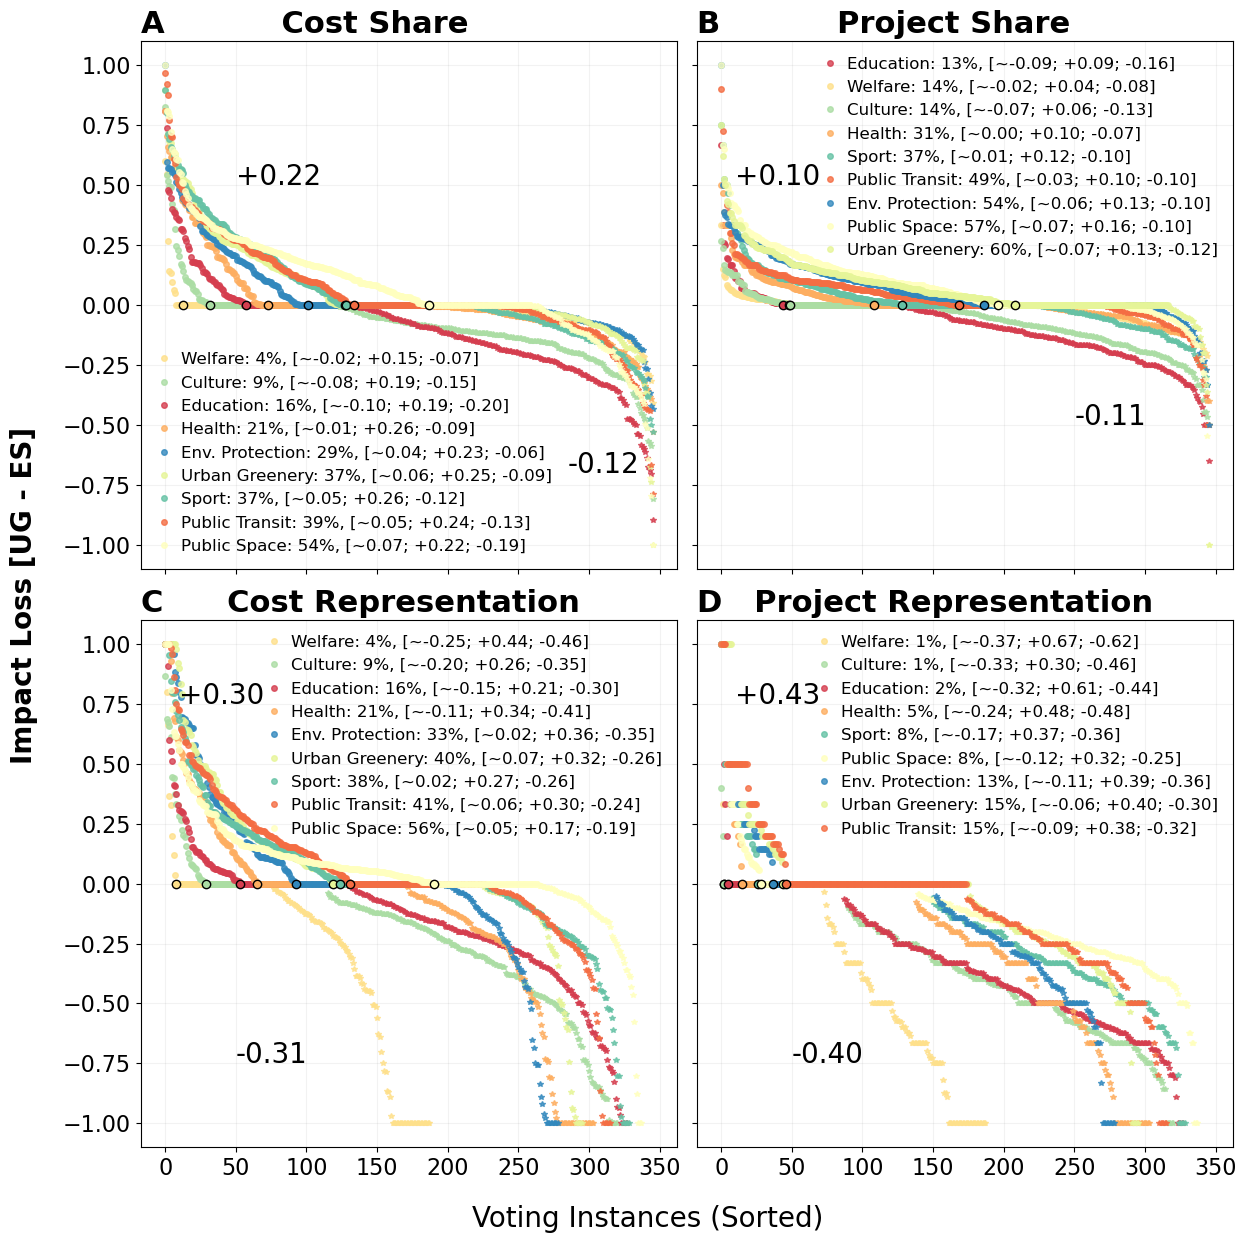

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

## first plot; budget share
bsflippingPoints = {
}

bs_num_election_map = {
}


# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_share']]
    temp_df.drop_duplicates(inplace=True)
    bs_num_election_map[category] = temp_df[f'{category}_loss_cost_share'].count()
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_share']].sort_values(by=f'{category}_loss_cost_share', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_cost_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_cost_share'] > 0)):
            bsflippingPoints[category] = i
            threshold_found = True
            break

bsflippingPointsSorted = sorted(bsflippingPoints, key=bsflippingPoints.get)
overall_bs_positive = []
overall_bs_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(bsflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = bsflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / bs_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_share']].sort_values(by=f'{category}_loss_cost_share', ascending=False).reset_index()

    diff_relative_winners_cost_pct_category_avg = np.mean(diff_relative_winners_cost_pct_category[f'{category}_loss_cost_share'])
    diff_relative_winners_cost_pct_category_positive_avg = np.mean(diff_relative_winners_cost_pct_category[diff_relative_winners_cost_pct_category[f'{category}_loss_cost_share'] > 0][f'{category}_loss_cost_share'])
    diff_relative_winners_cost_pct_category_negative_avg = np.mean(diff_relative_winners_cost_pct_category[diff_relative_winners_cost_pct_category[f'{category}_loss_cost_share'] < 0][f'{category}_loss_cost_share'])

    overall_bs_positive.append(diff_relative_winners_cost_pct_category_positive_avg)
    overall_bs_negative.append(diff_relative_winners_cost_pct_category_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_cost_pct_category_avg:.2f}; +{diff_relative_winners_cost_pct_category_positive_avg:.2f}; {diff_relative_winners_cost_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_winners_cost_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][0].plot(
                i, row[f'{category}_loss_cost_share'],
                marker='o' if row[f'{category}_loss_cost_share'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_cost_share'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][0].plot(
                    i, row[f'{category}_loss_cost_share'], 
                    marker='o' if row[f'{category}_loss_cost_share'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(bsflippingPointsSorted):
    # threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_share']].sort_values(by=f'{category}_loss_cost_share', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = bsflippingPoints[category]

    for i, row in diff_relative_winners_cost_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[0][0].plot(
                    i, row[f'{category}_loss_cost_share'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_bs_positive_avg = np.mean(overall_bs_positive)
overall_bs_negative_avg = np.mean(overall_bs_negative)

axes[0][0].annotate(f'+{overall_bs_positive_avg:.2f}', xy=(0, 0), xytext=(50, 0.5), fontsize=20)
axes[0][0].annotate(f'{overall_bs_negative_avg:.2f}', xy=(0, 0), xytext=(285, -0.7), fontsize=20)

axes[0][0].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[0][0].set_title("A           Cost Share", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[0][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][0].tick_params(axis='both', labelsize=16)
## end of first plot

## second plot; winning rate
wrflippingPoints = {
}

wr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_share']]
    temp_df.drop_duplicates(inplace=True)
    wr_num_election_map[category] = temp_df[f'{category}_loss_project_share'].count()
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'{category}_loss_project_share']].sort_values(by=f'{category}_loss_project_share', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_count_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_project_share'] > 0)):
            wrflippingPoints[category] = i
            threshold_found = True
            break

wrflippingPointsSorted = sorted(wrflippingPoints, key=wrflippingPoints.get)

overall_wr_positive = []
overall_wr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(wrflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = wrflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / wr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_project_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'{category}_loss_project_share']].sort_values(by=f'{category}_loss_project_share', ascending=False).reset_index()
    
    diff_relative_winners_count_pct_category_avg = np.mean(diff_relative_winners_count_pct_category[f'{category}_loss_project_share'])
    diff_relative_winners_count_pct_category_positive_avg = np.mean(diff_relative_winners_count_pct_category[diff_relative_winners_count_pct_category[f'{category}_loss_project_share'] > 0][f'{category}_loss_project_share'])
    diff_relative_winners_count_pct_category_negative_avg = np.mean(diff_relative_winners_count_pct_category[diff_relative_winners_count_pct_category[f'{category}_loss_project_share'] < 0][f'{category}_loss_project_share'])
    
    overall_wr_positive.append(diff_relative_winners_count_pct_category_positive_avg)
    overall_wr_negative.append(diff_relative_winners_count_pct_category_negative_avg)
    
    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_count_pct_category_avg:.2f}; +{diff_relative_winners_count_pct_category_positive_avg:.2f}; {diff_relative_winners_count_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_winners_count_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][1].plot(
                i, row[f'{category}_loss_project_share'],
                marker='o' if row[f'{category}_loss_project_share'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_project_share'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][1].plot(
                    i, row[f'{category}_loss_project_share'], 
                    marker='o' if row[f'{category}_loss_project_share'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(wrflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'{category}_loss_project_share']].sort_values(by=f'{category}_loss_project_share', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = wrflippingPoints[category]

    for i, row in diff_relative_winners_count_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[0][1].plot(
                    i, row[f'{category}_loss_project_share'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_wr_positive_avg = np.mean(overall_wr_positive)
overall_wr_negative_avg = np.mean(overall_wr_negative)

axes[0][1].annotate(f'+{overall_wr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.5), fontsize=20)
axes[0][1].annotate(f'{overall_wr_negative_avg:.2f}', xy=(0, 0), xytext=(250, -0.5), fontsize=20)

axes[0][1].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[0][1].set_title("B           Project Share", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[0][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][0].tick_params(axis='both', labelsize=16)
## end of second plot

## third plot; cost representation
crflippingPoints = {
}

cr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_rep']]
    temp_df.drop_duplicates(inplace=True)
    cr_num_election_map[category] = temp_df[f'{category}_loss_cost_rep'].count()
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_rep']].sort_values(by=f'{category}_loss_cost_rep', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_cost_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_cost_rep'] > 0)):
            crflippingPoints[category] = i
            threshold_found = True
            break

crflippingPointsSorted = sorted(crflippingPoints, key=crflippingPoints.get)

overall_cr_positive = []
overall_cr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(crflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = crflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / cr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_rep']].sort_values(by=f'{category}_loss_cost_rep', ascending=False).reset_index()
    
    diff_relative_proposals_cost_pct_category_avg = np.mean(diff_relative_proposals_cost_pct_category[f'{category}_loss_cost_rep'])
    diff_relative_proposals_cost_pct_category_positive_avg = np.mean(diff_relative_proposals_cost_pct_category[diff_relative_proposals_cost_pct_category[f'{category}_loss_cost_rep'] > 0][f'{category}_loss_cost_rep'])
    diff_relative_proposals_cost_pct_category_negative_avg = np.mean(diff_relative_proposals_cost_pct_category[diff_relative_proposals_cost_pct_category[f'{category}_loss_cost_rep'] < 0][f'{category}_loss_cost_rep'])
    
    overall_cr_positive.append(diff_relative_proposals_cost_pct_category_positive_avg)
    overall_cr_negative.append(diff_relative_proposals_cost_pct_category_negative_avg)
    
    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_cost_pct_category_avg:.2f}; +{diff_relative_proposals_cost_pct_category_positive_avg:.2f}; {diff_relative_proposals_cost_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_cost_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][0].plot(
                i, row[f'{category}_loss_cost_rep'],
                marker='o' if row[f'{category}_loss_cost_rep'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_cost_rep'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][0].plot(
                    i, row[f'{category}_loss_cost_rep'], 
                    marker='o' if row[f'{category}_loss_cost_rep'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(crflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_rep']].sort_values(by=f'{category}_loss_cost_rep', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = crflippingPoints[category]

    for i, row in diff_relative_proposals_cost_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[1][0].plot(
                    i, row[f'{category}_loss_cost_rep'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_cr_positive_avg = np.mean(overall_cr_positive)
overall_cr_negative_avg = np.mean(overall_cr_negative)

axes[1][0].annotate(f'+{overall_cr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.75), fontsize=20)
axes[1][0].annotate(f'{overall_cr_negative_avg:.2f}', xy=(0, 0), xytext=(50, -0.75), fontsize=20)

axes[1][0].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[1][0].set_title("C      Cost Representation", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[1][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][0].tick_params(axis='both', labelsize=16)
## end of third plot

## fourth plot; project representation
rrflippingPoints = {
}

rr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_rep']]
    temp_df.drop_duplicates(inplace=True)
    rr_num_election_map[category] = temp_df[f'{category}_loss_project_rep'].count()
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'{category}_loss_project_rep']].sort_values(by=f'{category}_loss_project_rep', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_count_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_project_rep'] > 0)):
            rrflippingPoints[category] = i
            threshold_found = True
            break

rrflippingPointsSorted = sorted(rrflippingPoints, key=rrflippingPoints.get)

overall_rr_positive = []
overall_rr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(rrflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = rrflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / rr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_project_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'{category}_loss_project_rep']].sort_values(by=f'{category}_loss_project_rep', ascending=False).reset_index()
    
    diff_relative_proposals_count_pct_category_avg = np.mean(diff_relative_proposals_count_pct_category[f'{category}_loss_project_rep'])
    diff_relative_proposals_count_pct_category_positive_avg = np.mean(diff_relative_proposals_count_pct_category[diff_relative_proposals_count_pct_category[f'{category}_loss_project_rep'] > 0][f'{category}_loss_project_rep'])
    diff_relative_proposals_count_pct_category_negative_avg = np.mean(diff_relative_proposals_count_pct_category[diff_relative_proposals_count_pct_category[f'{category}_loss_project_rep'] < 0][f'{category}_loss_project_rep'])

    overall_rr_positive.append(diff_relative_proposals_count_pct_category_positive_avg)
    overall_rr_negative.append(diff_relative_proposals_count_pct_category_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_count_pct_category_avg:.2f}; +{diff_relative_proposals_count_pct_category_positive_avg:.2f}; {diff_relative_proposals_count_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_count_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][1].plot(
                i, row[f'{category}_loss_project_rep'],
                marker='o' if row[f'{category}_loss_project_rep'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_project_rep'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][1].plot(
                    i, row[f'{category}_loss_project_rep'], 
                    marker='o' if row[f'{category}_loss_project_rep'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(rrflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'{category}_loss_project_rep']].sort_values(by=f'{category}_loss_project_rep', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = rrflippingPoints[category]

    for i, row in diff_relative_proposals_count_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[1][1].plot(
                    i, row[f'{category}_loss_project_rep'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_rr_positive_avg = np.mean(overall_rr_positive)
overall_rr_negative_avg = np.mean(overall_rr_negative)

axes[1][1].annotate(f'+{overall_rr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.75), fontsize=20)
axes[1][1].annotate(f'{overall_rr_negative_avg:.2f}', xy=(0, 0), xytext=(50, -0.75), fontsize=20)

axes[1][1].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[1][1].set_title("D   Project Representation", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[1][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][1].tick_params(axis='both', labelsize=16)
## end of fourth plot

fig.text(0.5, -0.02, 'Voting Instances (Sorted)', fontsize=20, ha='center', va='center')
fig.text(-0.02, 0.5, 'Impact Loss [UG - ES]', ha='center', va='center', rotation='vertical', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

# New plot for share and representation across cost, number nad popularity

C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\272514890.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\272514890.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25352\272514890.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicat

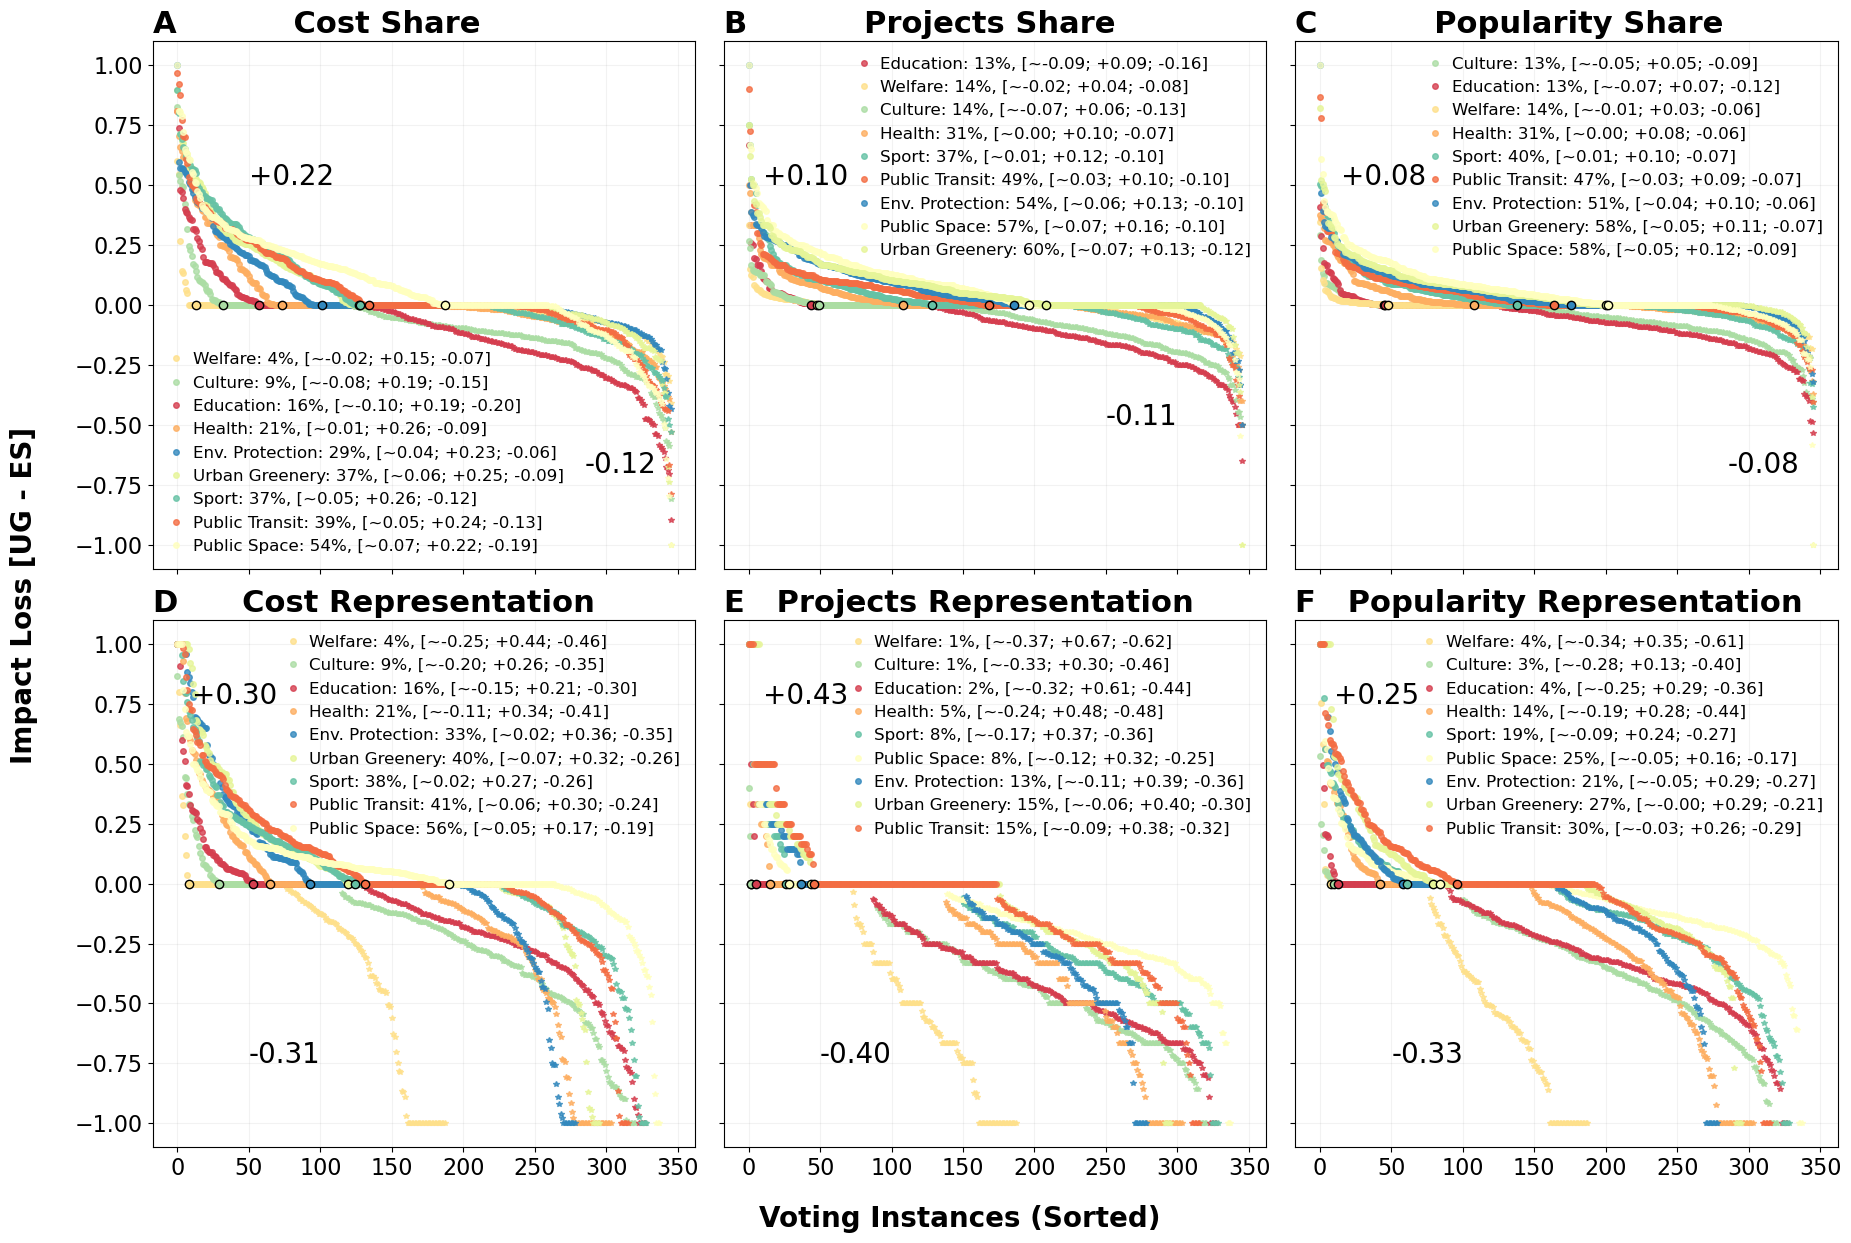

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)

## first plot; cost share
bsflippingPoints = {
}

bs_num_election_map = {
}


# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_share']]
    temp_df.drop_duplicates(inplace=True)
    bs_num_election_map[category] = temp_df[f'{category}_loss_cost_share'].count()
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_share']].sort_values(by=f'{category}_loss_cost_share', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_cost_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_cost_share'] > 0)):
            bsflippingPoints[category] = i
            threshold_found = True
            break

bsflippingPointsSorted = sorted(bsflippingPoints, key=bsflippingPoints.get)
overall_bs_positive = []
overall_bs_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(bsflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = bsflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / bs_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_share']].sort_values(by=f'{category}_loss_cost_share', ascending=False).reset_index()

    diff_relative_winners_cost_pct_category_avg = np.mean(diff_relative_winners_cost_pct_category[f'{category}_loss_cost_share'])
    diff_relative_winners_cost_pct_category_positive_avg = np.mean(diff_relative_winners_cost_pct_category[diff_relative_winners_cost_pct_category[f'{category}_loss_cost_share'] > 0][f'{category}_loss_cost_share'])
    diff_relative_winners_cost_pct_category_negative_avg = np.mean(diff_relative_winners_cost_pct_category[diff_relative_winners_cost_pct_category[f'{category}_loss_cost_share'] < 0][f'{category}_loss_cost_share'])

    overall_bs_positive.append(diff_relative_winners_cost_pct_category_positive_avg)
    overall_bs_negative.append(diff_relative_winners_cost_pct_category_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_cost_pct_category_avg:.2f}; +{diff_relative_winners_cost_pct_category_positive_avg:.2f}; {diff_relative_winners_cost_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_winners_cost_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][0].plot(
                i, row[f'{category}_loss_cost_share'],
                marker='o' if row[f'{category}_loss_cost_share'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_cost_share'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][0].plot(
                    i, row[f'{category}_loss_cost_share'], 
                    marker='o' if row[f'{category}_loss_cost_share'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(bsflippingPointsSorted):
    # threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_share']].sort_values(by=f'{category}_loss_cost_share', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = bsflippingPoints[category]

    for i, row in diff_relative_winners_cost_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[0][0].plot(
                    i, row[f'{category}_loss_cost_share'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_bs_positive_avg = np.mean(overall_bs_positive)
overall_bs_negative_avg = np.mean(overall_bs_negative)

axes[0][0].annotate(f'+{overall_bs_positive_avg:.2f}', xy=(0, 0), xytext=(50, 0.5), fontsize=20)
axes[0][0].annotate(f'{overall_bs_negative_avg:.2f}', xy=(0, 0), xytext=(285, -0.7), fontsize=20)

axes[0][0].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[0][0].set_title("A           Cost Share", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[0][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][0].tick_params(axis='both', labelsize=16)
## end of cost share

## second plot; project share
wrflippingPoints = {
}

wr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_share']]
    temp_df.drop_duplicates(inplace=True)
    wr_num_election_map[category] = temp_df[f'{category}_loss_project_share'].count()
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'{category}_loss_project_share']].sort_values(by=f'{category}_loss_project_share', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_count_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_project_share'] > 0)):
            wrflippingPoints[category] = i
            threshold_found = True
            break

wrflippingPointsSorted = sorted(wrflippingPoints, key=wrflippingPoints.get)

overall_wr_positive = []
overall_wr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(wrflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = wrflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / wr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_project_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'{category}_loss_project_share']].sort_values(by=f'{category}_loss_project_share', ascending=False).reset_index()
    
    diff_relative_winners_count_pct_category_avg = np.mean(diff_relative_winners_count_pct_category[f'{category}_loss_project_share'])
    diff_relative_winners_count_pct_category_positive_avg = np.mean(diff_relative_winners_count_pct_category[diff_relative_winners_count_pct_category[f'{category}_loss_project_share'] > 0][f'{category}_loss_project_share'])
    diff_relative_winners_count_pct_category_negative_avg = np.mean(diff_relative_winners_count_pct_category[diff_relative_winners_count_pct_category[f'{category}_loss_project_share'] < 0][f'{category}_loss_project_share'])
    
    overall_wr_positive.append(diff_relative_winners_count_pct_category_positive_avg)
    overall_wr_negative.append(diff_relative_winners_count_pct_category_negative_avg)
    
    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_count_pct_category_avg:.2f}; +{diff_relative_winners_count_pct_category_positive_avg:.2f}; {diff_relative_winners_count_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_winners_count_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][1].plot(
                i, row[f'{category}_loss_project_share'],
                marker='o' if row[f'{category}_loss_project_share'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_project_share'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][1].plot(
                    i, row[f'{category}_loss_project_share'], 
                    marker='o' if row[f'{category}_loss_project_share'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(wrflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_share']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'{category}_loss_project_share']].sort_values(by=f'{category}_loss_project_share', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = wrflippingPoints[category]

    for i, row in diff_relative_winners_count_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[0][1].plot(
                    i, row[f'{category}_loss_project_share'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_wr_positive_avg = np.mean(overall_wr_positive)
overall_wr_negative_avg = np.mean(overall_wr_negative)

axes[0][1].annotate(f'+{overall_wr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.5), fontsize=20)
axes[0][1].annotate(f'{overall_wr_negative_avg:.2f}', xy=(0, 0), xytext=(250, -0.5), fontsize=20)

axes[0][1].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[0][1].set_title("B           Projects Share", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[0][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][1].tick_params(axis='both', labelsize=16)
## end of project share

## third plot; popularity share
psflippingPoints = {
}

ps_num_election_map = {
}


# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_popularity_share']]
    temp_df.drop_duplicates(inplace=True)
    ps_num_election_map[category] = temp_df[f'{category}_loss_popularity_share'].count()
    category_loss_popularity_share = temp_df[['election_id', f'{category}_loss_popularity_share']].sort_values(by=f'{category}_loss_popularity_share', ascending=False).reset_index()
    
    for i, row in category_loss_popularity_share.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_popularity_share'] > 0)):
            psflippingPoints[category] = i
            threshold_found = True
            break

psflippingPointsSorted = sorted(psflippingPoints, key=psflippingPoints.get)
overall_ps_positive = []
overall_ps_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(psflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = psflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / ps_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_popularity_share']]
    temp_df.drop_duplicates(inplace=True)
    category_loss_popularity_share = temp_df[['election_id', f'{category}_loss_popularity_share']].sort_values(by=f'{category}_loss_popularity_share', ascending=False).reset_index()

    category_loss_popularity_share_avg = np.mean(category_loss_popularity_share[f'{category}_loss_popularity_share'])
    category_loss_popularity_share_positive_avg = np.mean(category_loss_popularity_share[category_loss_popularity_share[f'{category}_loss_popularity_share'] > 0][f'{category}_loss_popularity_share'])
    category_loss_popularity_share_negative_avg = np.mean(category_loss_popularity_share[category_loss_popularity_share[f'{category}_loss_popularity_share'] < 0][f'{category}_loss_popularity_share'])

    overall_ps_positive.append(category_loss_popularity_share_positive_avg)
    overall_ps_negative.append(category_loss_popularity_share_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{category_loss_popularity_share_avg:.2f}; +{category_loss_popularity_share_positive_avg:.2f}; {category_loss_popularity_share_negative_avg:.2f}]'

    for i, row in category_loss_popularity_share.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][2].plot(
                i, row[f'{category}_loss_popularity_share'],
                marker='o' if row[f'{category}_loss_popularity_share'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_popularity_share'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][2].plot(
                    i, row[f'{category}_loss_popularity_share'], 
                    marker='o' if row[f'{category}_loss_popularity_share'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(psflippingPointsSorted):
    # threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_popularity_share']]
    temp_df.drop_duplicates(inplace=True)
    category_loss_popularity_share = temp_df[['election_id', f'{category}_loss_popularity_share']].sort_values(by=f'{category}_loss_popularity_share', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = psflippingPoints[category]

    for i, row in category_loss_popularity_share.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[0][2].plot(
                    i, row[f'{category}_loss_popularity_share'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_ps_positive_avg = np.mean(overall_ps_positive)
overall_ps_negative_avg = np.mean(overall_ps_negative)

axes[0][2].annotate(f'+{overall_ps_positive_avg:.2f}', xy=(0, 0), xytext=(15, 0.5), fontsize=20)
axes[0][2].annotate(f'{overall_ps_negative_avg:.2f}', xy=(0, 0), xytext=(285, -0.7), fontsize=20)

axes[0][2].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[0][2].set_title("C           Popularity Share", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[0][2].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][2].tick_params(axis='both', labelsize=16)
## end of popularity share

## fourth plot; cost representation
crflippingPoints = {
}

cr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_rep']]
    temp_df.drop_duplicates(inplace=True)
    cr_num_election_map[category] = temp_df[f'{category}_loss_cost_rep'].count()
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_rep']].sort_values(by=f'{category}_loss_cost_rep', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_cost_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_cost_rep'] > 0)):
            crflippingPoints[category] = i
            threshold_found = True
            break

crflippingPointsSorted = sorted(crflippingPoints, key=crflippingPoints.get)

overall_cr_positive = []
overall_cr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(crflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = crflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / cr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_rep']].sort_values(by=f'{category}_loss_cost_rep', ascending=False).reset_index()
    
    diff_relative_proposals_cost_pct_category_avg = np.mean(diff_relative_proposals_cost_pct_category[f'{category}_loss_cost_rep'])
    diff_relative_proposals_cost_pct_category_positive_avg = np.mean(diff_relative_proposals_cost_pct_category[diff_relative_proposals_cost_pct_category[f'{category}_loss_cost_rep'] > 0][f'{category}_loss_cost_rep'])
    diff_relative_proposals_cost_pct_category_negative_avg = np.mean(diff_relative_proposals_cost_pct_category[diff_relative_proposals_cost_pct_category[f'{category}_loss_cost_rep'] < 0][f'{category}_loss_cost_rep'])
    
    overall_cr_positive.append(diff_relative_proposals_cost_pct_category_positive_avg)
    overall_cr_negative.append(diff_relative_proposals_cost_pct_category_negative_avg)
    
    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_cost_pct_category_avg:.2f}; +{diff_relative_proposals_cost_pct_category_positive_avg:.2f}; {diff_relative_proposals_cost_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_cost_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][0].plot(
                i, row[f'{category}_loss_cost_rep'],
                marker='o' if row[f'{category}_loss_cost_rep'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_cost_rep'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][0].plot(
                    i, row[f'{category}_loss_cost_rep'], 
                    marker='o' if row[f'{category}_loss_cost_rep'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(crflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_cost_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'{category}_loss_cost_rep']].sort_values(by=f'{category}_loss_cost_rep', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = crflippingPoints[category]

    for i, row in diff_relative_proposals_cost_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[1][0].plot(
                    i, row[f'{category}_loss_cost_rep'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_cr_positive_avg = np.mean(overall_cr_positive)
overall_cr_negative_avg = np.mean(overall_cr_negative)

axes[1][0].annotate(f'+{overall_cr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.75), fontsize=20)
axes[1][0].annotate(f'{overall_cr_negative_avg:.2f}', xy=(0, 0), xytext=(50, -0.75), fontsize=20)

axes[1][0].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[1][0].set_title("D      Cost Representation", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[1][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][0].tick_params(axis='both', labelsize=16)
## end of cost representation

## fifth plot; project representation
rrflippingPoints = {
}

rr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_rep']]
    temp_df.drop_duplicates(inplace=True)
    rr_num_election_map[category] = temp_df[f'{category}_loss_project_rep'].count()
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'{category}_loss_project_rep']].sort_values(by=f'{category}_loss_project_rep', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_count_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_project_rep'] > 0)):
            rrflippingPoints[category] = i
            threshold_found = True
            break

rrflippingPointsSorted = sorted(rrflippingPoints, key=rrflippingPoints.get)

overall_rr_positive = []
overall_rr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(rrflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = rrflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / rr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_project_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'{category}_loss_project_rep']].sort_values(by=f'{category}_loss_project_rep', ascending=False).reset_index()
    
    diff_relative_proposals_count_pct_category_avg = np.mean(diff_relative_proposals_count_pct_category[f'{category}_loss_project_rep'])
    diff_relative_proposals_count_pct_category_positive_avg = np.mean(diff_relative_proposals_count_pct_category[diff_relative_proposals_count_pct_category[f'{category}_loss_project_rep'] > 0][f'{category}_loss_project_rep'])
    diff_relative_proposals_count_pct_category_negative_avg = np.mean(diff_relative_proposals_count_pct_category[diff_relative_proposals_count_pct_category[f'{category}_loss_project_rep'] < 0][f'{category}_loss_project_rep'])

    overall_rr_positive.append(diff_relative_proposals_count_pct_category_positive_avg)
    overall_rr_negative.append(diff_relative_proposals_count_pct_category_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_count_pct_category_avg:.2f}; +{diff_relative_proposals_count_pct_category_positive_avg:.2f}; {diff_relative_proposals_count_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_count_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][1].plot(
                i, row[f'{category}_loss_project_rep'],
                marker='o' if row[f'{category}_loss_project_rep'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_project_rep'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][1].plot(
                    i, row[f'{category}_loss_project_rep'], 
                    marker='o' if row[f'{category}_loss_project_rep'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(rrflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_project_rep']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'{category}_loss_project_rep']].sort_values(by=f'{category}_loss_project_rep', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = rrflippingPoints[category]

    for i, row in diff_relative_proposals_count_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[1][1].plot(
                    i, row[f'{category}_loss_project_rep'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_rr_positive_avg = np.mean(overall_rr_positive)
overall_rr_negative_avg = np.mean(overall_rr_negative)

axes[1][1].annotate(f'+{overall_rr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.75), fontsize=20)
axes[1][1].annotate(f'{overall_rr_negative_avg:.2f}', xy=(0, 0), xytext=(50, -0.75), fontsize=20)

axes[1][1].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[1][1].set_title("E   Projects Representation", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[1][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][1].tick_params(axis='both', labelsize=16)
## end of project representation

## sixth plot; popularity representation
vrflippingPoints = {
}

vr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_popularity_rep']]
    temp_df.drop_duplicates(inplace=True)
    vr_num_election_map[category] = temp_df[f'{category}_loss_popularity_rep'].count()
    category_loss_popularity_rep = temp_df[['election_id', f'{category}_loss_popularity_rep']].sort_values(by=f'{category}_loss_popularity_rep', ascending=False).reset_index()
    
    for i, row in category_loss_popularity_rep.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'{category}_loss_popularity_rep'] > 0)):
            vrflippingPoints[category] = i
            threshold_found = True
            break

vrflippingPointsSorted = sorted(vrflippingPoints, key=vrflippingPoints.get)

overall_vr_positive = []
overall_vr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(rrflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = vrflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / vr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'{category}_loss_popularity_rep']]
    temp_df.drop_duplicates(inplace=True)
    category_loss_popularity_rep = temp_df[['election_id', f'{category}_loss_popularity_rep']].sort_values(by=f'{category}_loss_popularity_rep', ascending=False).reset_index()
    
    category_loss_popularity_rep_avg = np.mean(category_loss_popularity_rep[f'{category}_loss_popularity_rep'])
    category_loss_popularity_rep_positive_avg = np.mean(category_loss_popularity_rep[category_loss_popularity_rep[f'{category}_loss_popularity_rep'] > 0][f'{category}_loss_popularity_rep'])
    category_loss_popularity_rep_negative_avg = np.mean(category_loss_popularity_rep[category_loss_popularity_rep[f'{category}_loss_popularity_rep'] < 0][f'{category}_loss_popularity_rep'])

    overall_vr_positive.append(category_loss_popularity_rep_positive_avg)
    overall_vr_negative.append(category_loss_popularity_rep_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{category_loss_popularity_rep_avg:.2f}; +{category_loss_popularity_rep_positive_avg:.2f}; {category_loss_popularity_rep_negative_avg:.2f}]'

    for i, row in category_loss_popularity_rep.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][2].plot(
                i, row[f'{category}_loss_popularity_rep'],
                marker='o' if row[f'{category}_loss_popularity_rep'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'{category}_loss_popularity_rep'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][2].plot(
                    i, row[f'{category}_loss_popularity_rep'], 
                    marker='o' if row[f'{category}_loss_popularity_rep'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(vrflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'{category}_loss_popularity_rep']]
    temp_df.drop_duplicates(inplace=True)
    category_loss_popularity_rep = temp_df[['election_id', f'{category}_loss_popularity_rep']].sort_values(by=f'{category}_loss_popularity_rep', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = vrflippingPoints[category]

    for i, row in category_loss_popularity_rep.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[1][2].plot(
                    i, row[f'{category}_loss_popularity_rep'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_vr_positive_avg = np.mean(overall_vr_positive)
overall_vr_negative_avg = np.mean(overall_vr_negative)

axes[1][2].annotate(f'+{overall_vr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.75), fontsize=20)
axes[1][2].annotate(f'{overall_vr_negative_avg:.2f}', xy=(0, 0), xytext=(50, -0.75), fontsize=20)

axes[1][2].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[1][2].set_title("F   Popularity Representation", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[1][2].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][2].tick_params(axis='both', labelsize=16)
## end of popularity representation

fig.text(0.5, -0.02, 'Voting Instances (Sorted)', fontsize=20, ha='center', va='center', fontweight='bold')
fig.text(-0.02, 0.5, 'Impact Loss [UG - ES]', ha='center', va='center', rotation='vertical', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()